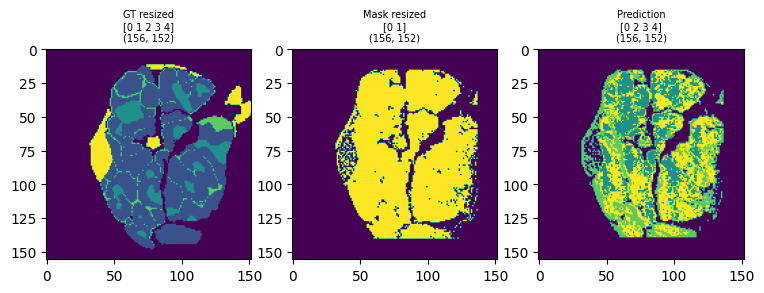

In [5]:
gc.collect()

fontsize=7
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].imshow(gt_res)
ax[0].set_title(f'GT resized\n{np.unique(gt_res)}\n{gt_res.shape}',fontsize=fontsize)
ax[1].imshow(mask_res)
ax[1].set_title(f'Mask resized\n{np.unique(mask_res)}\n{mask_res.shape}',fontsize=fontsize)
ax[2].imshow(pred)
ax[2].set_title(f'Prediction\n{np.unique(pred)}\n{pred.shape}',fontsize=fontsize)

plt.show()

##### **imports**

In [1]:
import tifffile as tf
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score

##### **functions**

In [2]:
def load_and_resize(gt_path, patch_labels_path):
    gt = tf.imread(gt_path)
    pred = np.load(patch_labels_path)
    
    target_shape = (pred.shape[1], pred.shape[0])
    gt_res = cv2.resize(gt, 
                        dsize=target_shape, 
                        interpolation=cv2.INTER_NEAREST)
    return pred, gt_res

def make_pair_jacc(gt_res, pred, save=False):
    
    # get gt and pred labels
    gt_lbls = np.unique(gt_res).astype(np.uint8)  
    pred_lbls = np.unique(pred).astype(np.uint8)

    gt_lbls = gt_lbls[1:]
    pred_lbls = pred_lbls[1:]

    # dataframe where jacc scores for all possible gt-pd labels are stored
    df = pd.DataFrame(columns=tuple([f'pd_{pred_lbl}' for pred_lbl in pred_lbls]))
    count = 0
    jaccs = []

    for gt_lbl in gt_lbls:
        gr_tr = np.where(gt_res==gt_lbl,1,0).astype(np.uint8)   

        for pd_lbl in pred_lbls:
            predict = np.where(pred==pd_lbl,1,0).astype(np.uint8)       
            
            jacc = jaccard_score(gr_tr, predict, average='micro') # calc jacc score labels=[1], average=None average=None
            jaccs.append(round(jacc,3))   

        df.loc[count] = jaccs
        jaccs = []
        count+=1

    df['index'] = [f'gt_{gt_lab}' for gt_lab in gt_lbls]
    df = df.set_index('index', drop=True)
    df.index.name = None
    # save df
    if save:
        df.to_csv(f'{save_path}all_pairs_jaccas.csv')
    return df

# the number of times we need to iterate over the df
def calc_times(df):
    if df.shape[0] == df.shape[1]:
        times = df.shape[0]
    else:
        times = min(df.shape)
    return times

# dataframe to store gt-pd pairs as well as max Jaccard values
def make_df_max(times):
    df_max = pd.DataFrame(columns=['gt', 'pd', 'max_Jacc'])
    df_max['index'] = range(times)
    df_max = df_max.set_index('index', drop=True)
    df_max.index.name = None
    return df_max

# find out WHAT the the max val is
def find_max_elem(df):
    max_elem = df.max().max()
    return max_elem

# find out WHERE the max val is
def find_max_elem_ind_col(df, max_elem):
    for col in df.columns:
        for ind in df.index:
            if df.at[ind, col] == max_elem:
                return ind, col
            
# add the pair and the max value to df_max
def add_to_max(ind, col, df, max_elem, df_max, time):
    ind, col = find_max_elem_ind_col(df, max_elem)
    df_max.loc[time] = [ind, col, max_elem]

# drop row and column where the max_elem is located
def drop_max(df, ind ,col):
    df.drop(col, axis=1, inplace=True)
    df.drop(str(ind), axis=0, inplace=True)
            
def run_paiwise_max_jacc(gt_path, patch_labels_path, save_path):
    pred, gt_res = load_and_resize(gt_path, patch_labels_path) # load
    
    df = make_pair_jacc(gt_res, pred, save=True) # original df is saved here
    times = calc_times(df) # the number of times we need to iterate over the df
    df_max = make_df_max(times) # dataframe to store gt-pd pairs as well as max Jaccard values
            
    for time in range(times):
        max_elem = find_max_elem(df)
        ind, col = find_max_elem_ind_col(df, max_elem)
        add_to_max(ind, col, df, max_elem, df_max, time)
        drop_max(df, ind ,col)
    
    df_max.to_csv(f'{save_path}pairs_max_jaccas.csv') # max parwise Jacc df is saved here

##### **run the whole thing**

In [3]:
# change paths
gt_path = '/path/to/ground_truth.tif'
patch_labels_path = '/path/to/patch_labels.npy'
save_path = '/save/path/'

run_paiwise_max_jacc(gt_path, patch_labels_path, save_path)